# Artificial Intelligence, Project 2.2

The project for the machine learning part is also split into two sub projects, this is the second part.

**Deadline:** 24.07.2018

Submit your solution (only the ipynb file) to AI.SS18@l3s.de using the subject:

```
AI18Project2.2:  [YourNames]
```

Please be sure to provide your matriculation numbers in the email.

File naming convention:

**`[FirstName]_[FamilyName]_[MatriculationNumber]_project_2_2.ipynb`**

Where `[FirstName]_[FamilyName]_[MatriculationNumber]` is added **per participant** in the group (max 2) and devided by a `_` if there are two group members.

In [1]:
import os
from pathlib import Path
import tensorflow as tf
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from matplotlib import cm
from PIL import Image
from skimage import data, io, filters

/Users/ophelia/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


Please download the CIFAR-10 dataset (Python version) from: https://www.cs.toronto.edu/~kriz/cifar.html

In [2]:
cifar_path = "/Users/ophelia/Downloads/cifar-10-batches-py"  

In [3]:
def get_cifar_filenames(path, train=True):
    if train:
        return list(map(str, Path(path).glob("*data_batch_*")))
    else:
        return list(map(str, Path(path).glob("*test_batch*")))

# Data
`generate_data` will yield tuples of (ndarray, int), where the ndarray either has the shape of the image `(128, 128, 3)` or `(128*128*3, 1)` if reshape is set to `True` and int is just the label with a value of 0 or 1.

It will also do some rough normalization to get the mean of the values to (approx.) 0 and variance to (approx.) 1. A complete pass through the data would be necessary to do this properly, but for images the implemented method is usually fine to start out with.

In [4]:
def generate_cifar_data(paths, reshape=True, normalize=True):
    import pickle

    for file in paths:
        #print(file)
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
            for i in range(10000):
                image = dict[bytes("data", "utf-8")][i]
                if normalize:
                    image = (image) / 256
                    
                if not reshape:
                    image = image.reshape(3, 32, 32).transpose([1, 2, 0])
                    
                yield image, dict[bytes("labels", "utf-8")][i]

In [5]:
data = generate_cifar_data(get_cifar_filenames(cifar_path, True))
print(next(data))

(array([0.23046875, 0.16796875, 0.1953125 , ..., 0.546875  , 0.328125  ,
       0.28125   ]), 6)


In [6]:
data = generate_cifar_data(get_cifar_filenames(cifar_path, False), reshape=False, normalize=True)
print(next(data))

(array([[[0.6171875 , 0.4375    , 0.19140625],
        [0.62109375, 0.43359375, 0.18359375],
        [0.64453125, 0.453125  , 0.19921875],
        ...,
        [0.53515625, 0.37109375, 0.140625  ],
        [0.4921875 , 0.35546875, 0.140625  ],
        [0.453125  , 0.33203125, 0.12890625]],

       [[0.59375   , 0.4375    , 0.19921875],
        [0.58984375, 0.4296875 , 0.15625   ],
        [0.62109375, 0.4453125 , 0.17578125],
        ...,
        [0.53125   , 0.37109375, 0.12109375],
        [0.48828125, 0.35546875, 0.125     ],
        [0.46484375, 0.34375   , 0.1328125 ]],

       [[0.58984375, 0.4296875 , 0.18359375],
        [0.58984375, 0.42578125, 0.12890625],
        [0.6171875 , 0.43359375, 0.140625  ],
        ...,
        [0.54296875, 0.3828125 , 0.1328125 ],
        [0.5078125 , 0.37109375, 0.1328125 ],
        [0.46875   , 0.34765625, 0.12890625]],

       ...,

       [[0.265625  , 0.484375  , 0.69140625],
        [0.1640625 , 0.390625  , 0.578125  ],
        [0.12109375, 

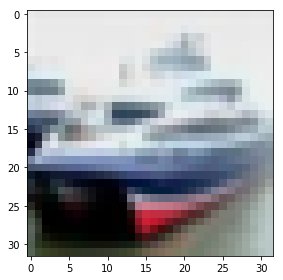

In [7]:
io.imshow(next(data)[0])

This will created batches of the given data and also reshape the labels to the correct dimensions.

In [8]:
def iter_batches(data, batch_size):
    while True:
        batch = itertools.islice(data, batch_size)
        try:
            examples, labels = [list(x) for x in zip(*batch)]
        except ValueError as e:
            #print("End of epoch reached:", e)
            break
            
        yield examples, np.asarray(labels).reshape(-1, 1)

In [20]:
def train_network(network, n_epochs=5, learning_rate=0.1, batch_size=32, reshape=True):
    if reshape:
        x = tf.placeholder(dtype=tf.float32, shape=[None, 3072], name="x")
    else:
        x = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3], name="x")

    y = tf.placeholder(dtype=tf.int32, shape=[None, 1], name="y")
    
    loss, optimizer, accuracy, y_pred = network(x, y, learning_rate)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(n_epochs):
            data = generate_cifar_data(get_cifar_filenames(cifar_path, True)[:2], reshape)
            loss_value, accuracy_acc, accuracy_cnt = (0,0,0)
            for examples, labels in iter_batches(data, batch_size):
                _, loss_value, accuracy_value = sess.run([optimizer, loss, accuracy],
                                                         feed_dict={x: examples,
                                                                    y: labels})
                accuracy_cnt += 1
                accuracy_acc += accuracy_value

            if epoch % 1 == 0:
                print("Epoch {%d}, Loss: {%f}, Accuracy: {%f}"%(epoch,loss_value,accuracy_acc / accuracy_cnt))
                data = generate_cifar_data(get_cifar_filenames(cifar_path, False), reshape)
                examples, labels = next(iter_batches(data, 256))
                accuracy_value, y_pred_value = sess.run([accuracy, y_pred], feed_dict={x: examples, y: labels})
                print("Test accuracy: {%f}"%(accuracy_value))
                #print(f"y_pred: {y_pred_value[:10]}, y: {labels[:10]}")
            
        data = generate_cifar_data(get_cifar_filenames(cifar_path, False), reshape)
        examples, labels = next(iter_batches(data, 1024))
        return sess.run(accuracy, feed_dict={x: examples, y: labels})

# Fully Connected

Implement a Neural Network consisting of three fully connected (dense) layers with dimensions:
* 512
* 256
* 10

Use sigmoid for the activation function of the first two layers, use no activation function for the last layer. For the loss use cross entrtopy loss.

Methods that will be useful:
* [tf.layers.dense](https://www.tensorflow.org/api_docs/python/tf/layers/dense)
* [tf.nn.sigmoid](https://www.tensorflow.org/api_docs/python/tf/sigmoid)
* [tf.nn.relu](https://www.tensorflow.org/api_docs/python/tf/relu)
* [tf.train.GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer)
* [tf.losses.sparse_softmax_cross_entropy](https://www.tensorflow.org/api_docs/python/tf/losses/sparse_softmax_cross_entropy)
* [tf.train.GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer)

Also: Do not expect the accuracy to be good! Train and test below 0.3.

In [21]:
def fc(x, y, learning_rate):
    # Your code goes here
    dense1 = tf.layers.dense(x, 512, activation=tf.nn.sigmoid)
    dense2 = tf.layers.dense(dense1, 256, activation=tf.nn.sigmoid)
    dense3 = tf.layers.dense(dense2, 10)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=dense3)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    # Note that you do not need to feed in the softmax output into the loss,
    # sparse_softmax_cross_entropy will already do that for you.
    # It is here only for computing the accuracy.
    softmax = tf.nn.softmax(dense3)
    y_pred = tf.argmax(softmax, axis=1)
    y_pred = tf.reshape(y_pred, (-1, 1))
    equality = tf.equal(tf.cast(y_pred, dtype=tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))
    
    return loss, optimizer, accuracy, y_pred

In [22]:
%time train_network(fc, learning_rate=0.01, n_epochs=15, batch_size=128, reshape=True)

Epoch {0}, Loss: {2.302760}, Accuracy: {0.115197}
Test accuracy: {0.187500}
Epoch {1}, Loss: {2.292102}, Accuracy: {0.167496}
Test accuracy: {0.218750}
Epoch {2}, Loss: {2.281847}, Accuracy: {0.197651}
Test accuracy: {0.265625}
Epoch {3}, Loss: {2.271760}, Accuracy: {0.216710}
Test accuracy: {0.281250}
Epoch {4}, Loss: {2.261656}, Accuracy: {0.231141}
Test accuracy: {0.273438}
Epoch {5}, Loss: {2.251436}, Accuracy: {0.240396}
Test accuracy: {0.285156}
Epoch {6}, Loss: {2.241112}, Accuracy: {0.248308}
Test accuracy: {0.289062}
Epoch {7}, Loss: {2.230812}, Accuracy: {0.254080}
Test accuracy: {0.292969}
Epoch {8}, Loss: {2.220737}, Accuracy: {0.259902}
Test accuracy: {0.296875}
Epoch {9}, Loss: {2.211102}, Accuracy: {0.263485}
Test accuracy: {0.289062}
Epoch {10}, Loss: {2.202074}, Accuracy: {0.268611}
Test accuracy: {0.285156}
Epoch {11}, Loss: {2.193739}, Accuracy: {0.272094}
Test accuracy: {0.289062}
Epoch {12}, Loss: {2.186115}, Accuracy: {0.274582}
Test accuracy: {0.300781}
Epoch {13

0.30273438

## Full Connected with relu
Implement the same network as above, but use relu as activation function.

Accuracy should improve quite a bit!

In [14]:
def fc2(x, y, learning_rate):
    # Your code goes here
    dense1 = tf.layers.dense(x, 512, activation=tf.nn.relu)
    dense2 = tf.layers.dense(dense1, 256, activation=tf.nn.relu)
    dense3 = tf.layers.dense(dense2, 10)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=dense3)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    softmax = tf.nn.softmax(dense3)
    y_pred = tf.argmax(softmax, axis=1)
    y_pred = tf.reshape(y_pred, (-1, 1))
    equality = tf.equal(tf.cast(y_pred, dtype=tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))
    return loss, optimizer, accuracy, y_pred

In [15]:
%time train_network(fc2, learning_rate=0.01, n_epochs=15, batch_size=128, reshape=True)

Epoch {epoch}, Loss: {loss_value}, Accuracy: {accuracy_acc / accuracy_cnt}
Test accuracy: {accuracy_value}
Epoch {epoch}, Loss: {loss_value}, Accuracy: {accuracy_acc / accuracy_cnt}
Test accuracy: {accuracy_value}
Epoch {epoch}, Loss: {loss_value}, Accuracy: {accuracy_acc / accuracy_cnt}
Test accuracy: {accuracy_value}
Epoch {epoch}, Loss: {loss_value}, Accuracy: {accuracy_acc / accuracy_cnt}
Test accuracy: {accuracy_value}
Epoch {epoch}, Loss: {loss_value}, Accuracy: {accuracy_acc / accuracy_cnt}
Test accuracy: {accuracy_value}
Epoch {epoch}, Loss: {loss_value}, Accuracy: {accuracy_acc / accuracy_cnt}
Test accuracy: {accuracy_value}
Epoch {epoch}, Loss: {loss_value}, Accuracy: {accuracy_acc / accuracy_cnt}
Test accuracy: {accuracy_value}
Epoch {epoch}, Loss: {loss_value}, Accuracy: {accuracy_acc / accuracy_cnt}
Test accuracy: {accuracy_value}
Epoch {epoch}, Loss: {loss_value}, Accuracy: {accuracy_acc / accuracy_cnt}
Test accuracy: {accuracy_value}
Epoch {epoch}, Loss: {loss_value}, Ac

0.40039062

# CNN

Methods that will be useful:
* [tf.layers.max_pooling2d](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d)
* [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d)
* [tf.layers.dense](https://www.tensorflow.org/api_docs/python/tf/layers/dense)
* [tf.nn.relu](https://www.tensorflow.org/api_docs/python/tf/relu)
* [tf.train.GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer)
* [tf.train.AdamOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer#minimize)

Build a network with:
* conv, kernel size 3, filter 8, stride 1, padding same, relu
* max pooling, pool size 3, stride 2
* conv, kernel size 3, filter 16, stride 1, padding same, relu
* max pooling, pool size 3, stride 2
* flatten
* dense, 256 neurons, relu
* dense, 512 neurons, relu

Results should be similar to fully connected with relu.

In [26]:
def cnn(x, y, learning_rate):
    # Your code goes here
    conv1 = tf.layers.conv2d(x, 8, 3,strides=1,padding='same',activation=tf.nn.relu)
    mp1 = tf.layers.max_pooling2d(conv1,3,2)
    conv2 = tf.layers.conv2d(mp1, 16, 3,strides=1,padding='same',activation=tf.nn.relu)
    mp2 = tf.layers.max_pooling2d(conv2,3,2)
    flat = tf.contrib.layers.flatten(mp2)
    dense1 = tf.layers.dense(flat, 256, activation=tf.nn.relu)
    dense2 = tf.layers.dense(dense1, 512, activation=tf.nn.relu)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=dense2)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    softmax = tf.nn.softmax(dense2)
    y_pred = tf.argmax(softmax, axis=1)
    y_pred = tf.reshape(y_pred, (-1, 1))
    equality = tf.equal(tf.cast(y_pred, dtype=tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))
    return loss, optimizer, accuracy, y_pred

In [27]:
%time train_network(cnn, learning_rate=0.01, n_epochs=10, batch_size=128, reshape=False)

Epoch {0}, Loss: {5.105136}, Accuracy: {0.112609}
Test accuracy: {0.097656}
Epoch {1}, Loss: {4.852138}, Accuracy: {0.160828}
Test accuracy: {0.117188}
Epoch {2}, Loss: {3.748439}, Accuracy: {0.186704}
Test accuracy: {0.140625}
Epoch {3}, Loss: {3.704221}, Accuracy: {0.210191}
Test accuracy: {0.148438}
Epoch {4}, Loss: {3.648896}, Accuracy: {0.231837}
Test accuracy: {0.175781}
Epoch {5}, Loss: {3.591486}, Accuracy: {0.251791}
Test accuracy: {0.195312}
Epoch {6}, Loss: {3.538408}, Accuracy: {0.268362}
Test accuracy: {0.214844}
Epoch {7}, Loss: {3.484173}, Accuracy: {0.290307}
Test accuracy: {0.222656}
Epoch {8}, Loss: {3.440550}, Accuracy: {0.303045}
Test accuracy: {0.230469}
Epoch {9}, Loss: {3.411798}, Accuracy: {0.317277}
Test accuracy: {0.246094}
CPU times: user 5min 21s, sys: 31.7 s, total: 5min 53s
Wall time: 2min 14s


0.2841797

## CNN, more complex
Build a network with:
* conv, kernel size 4, filter 16, stride 1, padding same, relu
* max pooling, pool size 3, stride 2
* conv, kernel size 4, filter 32, stride 1, padding same, relu
* max pooling, pool size 3, stride 2
* batchnorm
* conv, kernel size 4, filter 64, stride 1, padding same, relu
* max pooling, pool size 3, stride 2
* batchnorm
* flatten
* dense, 512 neurons, relu
* dense, 256 neurons, relu

Also: Use the Adam optimizer. (Notice that it takes a smaller learning rate compared to regular GD.)

Accuracy should again improve quite a bit, but it'll also take longer to train.

In [23]:
def cnn2(x, y, learning_rate):
    # Your code goes here
    conv1 = tf.layers.conv2d(x, 16, 4,strides=1,padding='same',activation=tf.nn.relu)
    mp1 = tf.layers.max_pooling2d(conv1,3,2)
    conv2 = tf.layers.conv2d(mp1, 32, 4,strides=1,padding='same',activation=tf.nn.relu)
    mp2 = tf.layers.max_pooling2d(conv2,3,2)
    bn1 = tf.layers.batch_normalization(mp2)
    conv3 = tf.layers.conv2d(bn1, 64, 4,strides=1,padding='same',activation=tf.nn.relu)
    mp3 = tf.layers.max_pooling2d(conv2,3,2)
    bn2 = tf.layers.batch_normalization(mp3)
    flat = tf.contrib.layers.flatten(bn2)
    dense1 = tf.layers.dense(flat, 256, activation=tf.nn.relu)
    dense2 = tf.layers.dense(dense1, 512, activation=tf.nn.relu)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=dense2)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    softmax = tf.nn.softmax(dense2)
    y_pred = tf.argmax(softmax, axis=1)
    y_pred = tf.reshape(y_pred, (-1, 1))
    equality = tf.equal(tf.cast(y_pred, dtype=tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))
    return loss, optimizer, accuracy, y_pred

In [24]:
%time train_network(cnn2, learning_rate=0.001, n_epochs=30, batch_size=128, reshape=False)

Epoch {0}, Loss: {1.723091}, Accuracy: {0.286077}
Test accuracy: {0.355469}
Epoch {1}, Loss: {1.607167}, Accuracy: {0.456758}
Test accuracy: {0.464844}
Epoch {2}, Loss: {1.427501}, Accuracy: {0.514431}
Test accuracy: {0.453125}
Epoch {3}, Loss: {1.248525}, Accuracy: {0.551055}
Test accuracy: {0.515625}
Epoch {4}, Loss: {1.079514}, Accuracy: {0.583648}
Test accuracy: {0.519531}
Epoch {5}, Loss: {0.916561}, Accuracy: {0.604996}
Test accuracy: {0.531250}
Epoch {6}, Loss: {0.790035}, Accuracy: {0.623905}
Test accuracy: {0.585938}
Epoch {7}, Loss: {0.691676}, Accuracy: {0.643561}
Test accuracy: {0.613281}
Epoch {8}, Loss: {0.616181}, Accuracy: {0.660330}
Test accuracy: {0.617188}
Epoch {9}, Loss: {0.540436}, Accuracy: {0.674910}
Test accuracy: {0.640625}
Epoch {10}, Loss: {0.465357}, Accuracy: {0.689490}
Test accuracy: {0.640625}
Epoch {11}, Loss: {0.415232}, Accuracy: {0.698895}
Test accuracy: {0.636719}
Epoch {12}, Loss: {0.365216}, Accuracy: {0.710440}
Test accuracy: {0.660156}
Epoch {13

0.6425781

# Questions / Discussion

__Set `n_epochs` to 9 for cnn2 and run it again. Describe what happens with the accuracy. What is that usually called? Is this neural network generalizing well?__

If we change `n_epochs` to 9, the accuracy would increase, but after epoch 10, the test accuracy stoped increasing when the accuracy of train keep increasing, the gap between these 2 accuracies become larger, we call this overfitting, which mean the learned weights can fit the train data very good but perform terrible on test data, the weights are not generalized for the all data, so the neural networl is not generalizing well.

__Set `n_epochs` to 10 for `fc` and run it again. Describe what happens with the accuracy. What is that usually called?__

If n_epochs for fc was set from 5 to 10, both train and test accuracies are increasing. In the case of 5 epochs, it is called underfitting.